In [1]:
#run with Python 3.11
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

Using device: cuda


In [3]:
#Hyperparams
batch_size = 128

## Data Preprocessing


In [4]:
def get_notes(load_existing = True):
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    if load_existing:
        print("loading existing notes")
        with open('data/notes', 'rb') as filepath:
            notes, durations = pickle.load(filepath)
            return notes, durations
    
    notes = []
    durations = []

    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                durations.append(element.duration.quarterLength)
                
                print("note", str(element.pitch), element.duration.quarterLength)
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                durations.append(element.duration.quarterLength)
                print("chord", '.'.join(str(n) for n in element.normalOrder), element.duration.quarterLength)

    with open('data/notes', 'wb') as filepath:
        pickle.dump((notes, durations), filepath)

    return notes, durations


#assemble training data in a readable format 
from preprocessing import prepare_sequences, encode_data


In [5]:
notes, durations = get_notes(load_existing=True) # set load_existing to True to skip reading in midi

# get amount of pitch names
n_vocab = len(set(notes))
d_vocab = len(set(durations))

network_input, network_output = prepare_sequences(notes, durations, n_vocab, d_vocab)

#build the dataset + dataloader
input_tensor = torch.tensor(network_input)
print("input tensor shape: ", input_tensor.shape)

output_tensor = torch.tensor(network_output)
print("output tensor shape: ", output_tensor.shape)

dataset = TensorDataset(input_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #1:36 w/ np

loading existing notes
input tensor shape:  torch.Size([45876, 100, 2])
output tensor shape:  torch.Size([45876, 2])


C:\Users\Archimedes Li\AppData\Local\Temp\ipykernel_23728\1074703379.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(network_input)
C:\Users\Archimedes Li\AppData\Local\Temp\ipykernel_23728\1074703379.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(network_output)


In [6]:
#view a single data shape
print(input_tensor[0].shape)
print(output_tensor[0].shape)

torch.Size([100, 2])
torch.Size([2])


## Model Architecture

In [ ]:
from models import MusicLSTM, MusicLSTM2

def train(num_epochs, model, train_dataloader, loss_func, optimizer):
    losses = []
    total_steps = len(train_dataloader)

    for epoch in range(num_epochs):
        for batch, (sequence, next_note) in enumerate(train_dataloader):
            #apply one-hot encoding to sequence and next_note
            sequence = encode_data(sequence, n_vocab, d_vocab, device, type="input")
            next_note = encode_data(next_note, n_vocab, d_vocab, device, type="output")

            output = model(sequence)
            loss = loss_func(output, next_note)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1)%100 == 0:
                print(f"Epoch: {epoch+1}; Batch {batch+1} / {total_steps}; Loss: {loss.item():>4f}")
        print(f"Epoch: {epoch+1} complete; Loss: {loss.item():>4f}")
    return losses

## Training

In [13]:
#set input len to 1
model = MusicLSTM2(input_len=1, hidden_size=1024, num_note_classes=n_vocab, num_duration_classes = d_vocab, num_layers=3)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

losses = train(num_epochs=150, model=model, loss_func=loss_function, optimizer=optimizer, train_dataloader=dataloader)


Epoch: 1; Batch 100 / 359; Loss: 7.853917
Epoch: 1; Batch 200 / 359; Loss: 7.462595
Epoch: 1; Batch 300 / 359; Loss: 7.900756
Epoch: 2; Batch 100 / 359; Loss: 7.351732
Epoch: 2; Batch 200 / 359; Loss: 7.437509
Epoch: 2; Batch 300 / 359; Loss: 7.267586
Epoch: 3; Batch 100 / 359; Loss: 7.184618
Epoch: 3; Batch 200 / 359; Loss: 6.903229
Epoch: 3; Batch 300 / 359; Loss: 6.695147
Epoch: 4; Batch 100 / 359; Loss: 6.791440
Epoch: 4; Batch 200 / 359; Loss: 6.637273
Epoch: 4; Batch 300 / 359; Loss: 6.800707
Epoch: 5; Batch 100 / 359; Loss: 6.518232
Epoch: 5; Batch 200 / 359; Loss: 6.262443
Epoch: 5; Batch 300 / 359; Loss: 6.133169
Epoch: 6; Batch 100 / 359; Loss: 6.135993
Epoch: 6; Batch 200 / 359; Loss: 6.282354
Epoch: 6; Batch 300 / 359; Loss: 6.149430
Epoch: 7; Batch 100 / 359; Loss: 5.780295
Epoch: 7; Batch 200 / 359; Loss: 5.747963
Epoch: 7; Batch 300 / 359; Loss: 5.687868
Epoch: 8; Batch 100 / 359; Loss: 5.704431
Epoch: 8; Batch 200 / 359; Loss: 5.305029
Epoch: 8; Batch 300 / 359; Loss: 5

In [14]:
torch.save(model, "models/music_model.pt")

In [ ]:

#losses2 = train(num_epochs=50, model=model, loss_func=loss_function, optimizer=optimizer, train_dataloader=dataloader)


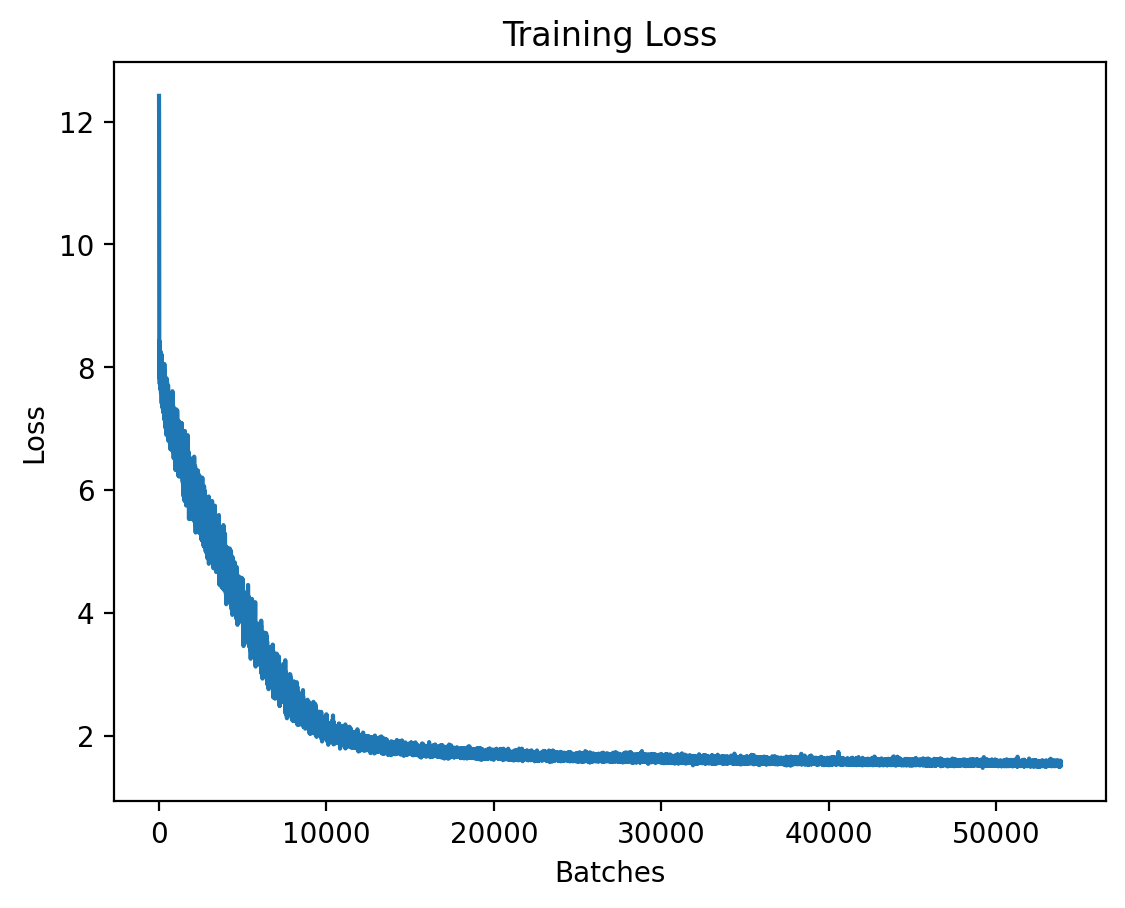

In [15]:
#plot losses
import matplotlib.pyplot as plt

plt.plot(losses)

plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.show()


In [ ]:

# def create_network(network_input, n_vocab):
#     """ create the structure of the neural network """
#     model = Sequential()
#     model.add(LSTM(
#         512,
#         input_shape=(network_input.shape[1], network_input.shape[2]), #input_shape=(# notes in a sequence = 100, # notes at once = 1)
#         recurrent_dropout=0.3,
#         return_sequences=True
#     ))
#     model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
#     model.add(LSTM(512))
#     model.add(BatchNorm())
#     model.add(Dropout(0.3))
#     model.add(Dense(256))
#     model.add(Activation('relu'))
#     model.add(BatchNorm())
#     model.add(Dropout(0.3))
#     model.add(Dense(n_vocab))
#     model.add(Activation('softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

#     return model

# def train(model, network_input, network_output):
#     """ train the neural network """
#     filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
#     checkpoint = ModelCheckpoint(
#         filepath,
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         mode='min'
#     )
#     callbacks_list = [checkpoint]

#     model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)

# if __name__ == '__main__':
#     train_network()
